In [41]:
from collections import defaultdict
from typing import List, Tuple

import imageio.v2 as imageio
import numpy as np
import numpy.typing as npt
import random
import os


In [42]:
# Calculate error
def root_mean_sq_err(ref_image, gen_image):
    m, n, _ = gen_image.shape
    subtracted_image = gen_image - ref_image
    squared_image = np.square(subtracted_image)
    mean_image = squared_image / (n * m)
    err = np.sum(mean_image)

    return np.sqrt(err)


In [43]:
def distance(
    query: npt.NDArray[np.float32], reference: npt.NDArray[np.float32]
) -> float:
    return np.linalg.norm(query - reference)


def find_closest_cluster(
    feature: npt.NDArray[np.float32], centroids: List[npt.NDArray[np.float32]]
) -> int:
    centr_ranks = [distance(feature, centroid) for centroid in centroids]
    closest = np.argmin(centr_ranks)
    return closest


In [44]:
def k_means(
    features: npt.NDArray[np.float32],
    k: int,
    n: int,
    M: int,
    N: int,
    seed: int,
) -> List[int]:
    random.seed(seed)
    ids = np.sort(random.sample(range(0, M * N), k))
    centroids = np.array(features[ids], copy=True)
    clusters = np.zeros(features.shape[0], dtype=np.uint8)
    for _ in range(n):
        for index, feature in enumerate(features):
            closest_idx = find_closest_cluster(feature, centroids)
            clusters[index] = closest_idx
        for c in range(k):
            feat_idx = np.expand_dims(clusters == c, axis=1)
            feat_idx = np.repeat(feat_idx, features.shape[1], axis=1)
            sub_features = np.ma.masked_array(features, feat_idx)
            centroid = sub_features.mean(axis=0)
            centroids[c] = centroid
    return centroids, clusters


In [45]:
def create_XY_features(M, N):
    X = np.tile(np.reshape(np.arange(M), (M, 1)), (1, N))
    Y = np.tile(np.reshape(np.arange(N), (N, 1)), (M, 1))
    X = np.reshape(X, (M * N, 1))
    Y = np.reshape(Y, (M * N, 1))
    XY = np.concatenate((X, Y), axis=1)
    return XY


def lum_reshape(image, M, N):
    return np.reshape(
        (0.299 * image[:, :, 0]) + (0.587 * image[:, :, 1]) + (0.114 * image[:, :, 2]),
        (M * N, 1),
    )


In [46]:
def rgb_image_from(
    centroids: List[npt.NDArray[np.float32]],
    clusters: List[int],
    k: int,
    img_shape: Tuple,
):
    out_image = centroids[clusters % k]
    out_image = np.reshape(out_image, img_shape)
    return out_image


def gray_image_from(clusters, feat_shape, img_shape):
    out_image = np.zeros(feat_shape, dtype=np.float32)
    for index, centroid in clusters.items():
        out_image[index] = centroid
    out_image = np.reshape(out_image, img_shape)
    return out_image


In [47]:
BASE_PATH = '../tests/resources/TestCases-InputImages'
image_filename = os.path.join(BASE_PATH, 'image_1.png')
ref_image_filename = os.path.join(BASE_PATH, 'image_1_ref1.png')
attributes_type = 1
k = 5
n = 10
seed = 42 #nice

image = imageio.imread(image_filename).astype(np.float32)
ref_image = imageio.imread(ref_image_filename).astype(np.float32)

M, N, _ = image.shape

match attributes_type:
    case 1:
        features = np.reshape(image, (M*N, 3))
        centroids, clusters = k_means(features, k, n, M, N, seed)
        out_image = rgb_image_from(centroids, clusters, k, (M, N, 3))
    case 2:
        XY = create_XY_features(M, N)
        features = np.reshape(image, (M*N, 3))
        features = np.concatenate((features, XY), axis=1)
        centroids, clusters = k_means(features, k, n, M, N, seed)
        out_image = rgb_image_from(centroids, clusters, features.shape, (M, N, 3))
    case 3:
        features = lum_reshape(image, M, N)
        rgb = 0
        clusters = k_means(features, k, n, M, N, seed)
        out_image = gray_image_from(clusters, features.shape, (M, N, 1))
    case 4:
        features = lum_reshape(image, M, N)
        features = np.concatenate((features, create_XY_features(M, N)), axis=1)
        rgb = 0
        clusters = k_means(features, k, n, M, N, seed)
        out_image = gray_image_from(clusters, features.shape, (M, N, 1))
    case _:
        exit(1)

rmse = root_mean_sq_err(ref_image, out_image)
print(rmse)


263.90814


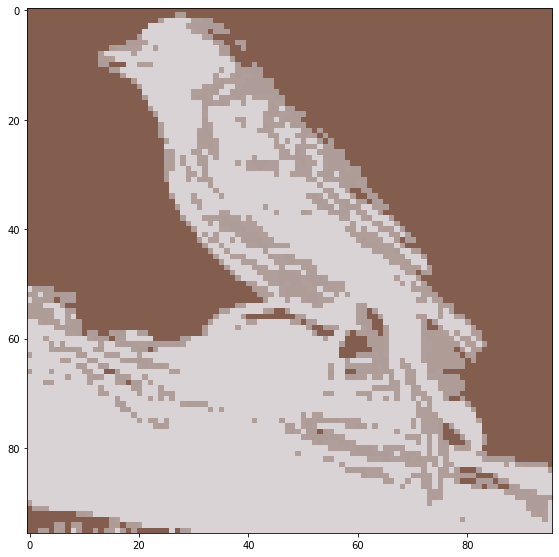

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 32))
plt.subplot(131)
plt.imshow(out_image.astype(np.uint8))

In [49]:
out_image.shape


(96, 96, 3)